In [48]:
import numpy as np
import math


def ESC(N, max_iter, lb, ub, dim, fobj):
    # Ensure bounds are arrays
    if np.isscalar(lb):
        lb = np.ones(dim) * lb
        ub = np.ones(dim) * ub

    # Initialize population
    population = np.random.rand(N, dim) * (ub - lb) + lb
    fitness = np.array([fobj(ind) for ind in population])
    idx = np.argsort(fitness)
    fitness = fitness[idx]
    population = population[idx]

    elite_size = 5
    beta_base = 1.5
    t = 0
    mask_probability = 0.5
    fitness_history = []
    best_solutions = population[:elite_size, :]

    def adaptive_levy_weight(beta_base, dim, t, max_iter):
        beta = beta_base + 0.5 * np.sin(np.pi / 2 * t / max_iter)
        beta = np.clip(beta, 0.1, 2)
        sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
                 (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
        u = np.random.normal(0, sigma, dim)
        v = np.random.normal(0, 1, dim)
        w = np.abs(u / np.abs(v) ** (1 / beta))
        return w / (np.max(w) + np.finfo(float).eps)

    while t < max_iter:
        panic_index = np.cos(np.pi / 2 * (t / (3 * max_iter)))
        idx = np.argsort(fitness)
        fitness = fitness[idx]
        population = population[idx]
        calm_count = int(round(0.15 * N))
        conform_count = int(round(0.35 * N))
        calm = population[:calm_count, :]
        conform = population[calm_count:calm_count + conform_count, :]
        panic = population[calm_count + conform_count:, :]
        calm_center = np.mean(calm, axis=0)

        new_population = population.copy()

        for i in range(N):



            if t / max_iter <= 0.5:
                if i < calm_count:
                    mask1 = np.random.rand(dim) > mask_probability
                    weight_vector1 = adaptive_levy_weight(beta_base, dim, t, max_iter)
                    random_position = np.min(calm, axis=0) + np.random.rand(dim) * (
                                np.max(calm, axis=0) - np.min(calm, axis=0))
                    new_population[i, :] += mask1 * (weight_vector1 * (calm_center - population[i, :]) +
                                                     (random_position - population[i, :] + np.random.randn(
                                                         dim) / 50) )* panic_index
                elif i < calm_count + conform_count:
                    mask1 = np.random.rand(dim) > mask_probability
                    mask2 = np.random.rand(dim) > mask_probability
                    weight_vector1 = adaptive_levy_weight(beta_base, dim, t, max_iter)
                    weight_vector2 = adaptive_levy_weight(beta_base, dim, t, max_iter)
                    random_position = np.min(conform, axis=0) + np.random.rand(dim) * (
                                np.max(conform, axis=0) - np.min(conform, axis=0))
                    panic_individual = panic[np.random.randint(panic.shape[0])] if len(panic) > 0 else np.zeros(dim)
                    new_population[i, :] += mask1 * (weight_vector1 * (calm_center - population[i, :]) +
                                                     mask2 * weight_vector2 * (panic_individual - population[i, :]) +
                                                     (random_position - population[i, :] + np.random.randn(
                                                         dim) / 50) * panic_index)
                else:
                    mask1 = np.random.rand(dim) > mask_probability
                    mask2 = np.random.rand(dim) > mask_probability
                    weight_vector1 = adaptive_levy_weight(beta_base, dim, t, max_iter)
                    weight_vector2 = adaptive_levy_weight(beta_base, dim, t, max_iter)
                    elite = best_solutions[np.random.randint(elite_size)]
                    random_individual = population[np.random.randint(N)]
                    random_position = elite + weight_vector1 * (random_individual - elite)
                    new_population[i, :] += mask1 * (weight_vector1 * (elite - population[i, :]) +
                                                     mask2 * weight_vector2 * (random_individual - population[i, :]) +
                                                     (random_position - population[i, :] + np.random.randn(
                                                         dim) / 50) * panic_index)
            else:
                mask1 = np.random.rand(dim) > mask_probability
                mask2 = np.random.rand(dim) > mask_probability
                weight_vector1 = adaptive_levy_weight(beta_base, dim, t, max_iter)
                weight_vector2 = adaptive_levy_weight(beta_base, dim, t, max_iter)
                elite = best_solutions[np.random.randint(elite_size)]
                random_individual = population[np.random.randint(N)]
                new_population[i, :] += mask1 * weight_vector1 * (elite - population[i, :]) + \
                                        mask2 * weight_vector2 * (random_individual - population[i, :])

        # Boundary control
        new_population = np.clip(new_population, lb, ub)

        # Evaluate new population
        new_fitness = np.array([fobj(ind) for ind in new_population])

        # Replace individuals with better fitness
        for i in range(N):
            if new_fitness[i] < fitness[i]:
                population[i, :] = new_population[i, :]
                fitness[i] = new_fitness[i]

        # Update elite pool
        idx = np.argsort(fitness)
        fitness = fitness[idx]
        population = population[idx]
        best_solutions = population[:elite_size, :]

        # Record best fitness
        fitness_history.append(fitness[0])
        t += 1

    return fitness[0], population[0, :], fitness_history



Best Position： [ 0.45000577  5.07443534  0.30037849 ...  0.17702695 -1.64811739
  0.28038432]
Best Score： 22523.306382667262


Best Position： [ 0.47393418  1.16720886 -3.61681933 ... -0.69440287 -1.74347966
 -0.62192991]
Best Score： 0.34712230215827333


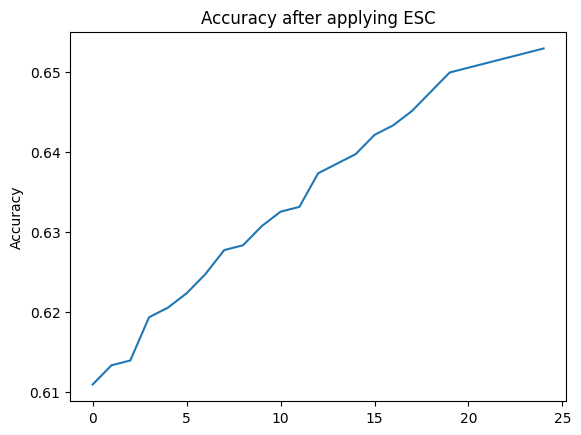

In [58]:

def test_function(x):
    # this is a simple test function
    return sum(x**2)

#parameter set

import numpy as np
import numbers as nb
from mealpy import FloatVar, SCA, SHIO, WHO
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# The goal:
# 1. Fill missing values randomly in the first iteration
# 2. Train the data using knn algorithm
# 3. Calculate the fitness
# 4. Generate new missing values vectors using the SCA algorithm using the calculated fitness
# repeat from inst 2 till the number of iterations  

# What is fitness

data = np.genfromtxt("../../water_potability.csv", delimiter=",", skip_header=1) 

scaler = StandardScaler()

features = data[:, 0:9]
target = data[:, 9]

scaler.fit(features)
features = scaler.transform(features)

accuracies = []

nan_indices = np.array([
    (row, col)  # Tuple of (row, column) indices
    for col in range(features.shape[1])
    for row in np.argwhere(np.isnan(features[:, col])).flatten()
])

nan_n = np.sum(np.isnan(features)) 

nan_mask = ~np.isnan(features).any(axis=1)
features_without_nan = features[nan_mask].copy()

lb = np.min(features_without_nan)
ub = np.max(features_without_nan)

original_indices_of_without_nan = np.where(nan_mask)[0]
original_indices_of_nan = np.where(~nan_mask)[0]



features_without_nan = features[original_indices_of_without_nan,:]
target_without_nan = target[original_indices_of_without_nan]

X_train, X_test, y_train, y_test = train_test_split(
    features_without_nan, target_without_nan, test_size=0.2, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

# Objective function will calculate the sum of squared vector passed to it
def objective_function(solution):
    # Assigning the solution to the dataset
    for k, (row, col) in enumerate(nan_indices):
        features[row, col] = solution[k]

    X_test_solution = np.concatenate((features[original_indices_of_nan, :], X_test), axis=0)
    y_test_solution = np.concatenate((target[original_indices_of_nan], y_test), axis=0)

    y_pred = knn.predict(X_test_solution)

    acc = accuracy_score(y_test_solution, y_pred)

    if(len(accuracies) == 0 or max(accuracies) < acc):
        accuracies.append(acc)

    fitness = 1 - acc
    return fitness

N = 5
Max_iter = 100
lb = lb
ub = ub
dim = nan_n

Best_score,Best_pos, fitness_history = ESC(N, Max_iter, lb, ub, dim, objective_function)

print("Best Position：", Best_pos)
print("Best Score：", Best_score)
# print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
# print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")


plt.plot(accuracies)
plt.title("Accuracy after applying ESC")
plt.ylabel("Accuracy")
plt.show()